# Time Gain by Acceleration

Goal:
- obtain chart that depicts average time per iteration as a function of the dataset size, for different datasets
- add error bars that show confidence interval of the iteration cost per N and Dataset

Steps:
 1. Gather experimental data using overview.csv and put everything in one DF with the following columns
   dataset_1 | seed | einstein | choice | run_1 | it_n | time_type | total_time
 2. Perform grouping of dataset

```
[
    {dataset_1 | seed | einstein | choice | run_1 | it_n | time_type | total_time},
    {dataset_1 | seed | einstein | choice | run_1 | it_n | time_type | total_time}
]
```

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_palette("colorblind")

In [2]:

# Change the path below to the directory that contains the overview.csv
results_path = Path("../results/exp_grid")

# Data Setup

Construction of dataframe that contains all data
`it_n | time_type | total_time | dataset | lr | perplexity | seed | sample_size | tsne_type | splitting_strategy | run | run_directory`

In [3]:
df = pd.read_csv(results_path.joinpath("overview.csv"))

include_tree_building = False

timings_dfs = []
for record in df.to_records():
    timing_df = pd.read_csv(record.run_directory.replace(".", str(results_path)) + "/timings.csv")

    if include_tree_building:
        timing_df = timing_df[(timing_df.time_type == "tot_gradient") |
                              (timing_df.time_type == "tree_building")].groupby(["it_n"]).sum().reset_index()
    else:
        timing_df = timing_df[(timing_df.time_type == "tot_gradient")]

    for cn in df.columns:
        timing_df[cn] = record[cn]
    timings_dfs.append(timing_df)

timings_df = pd.concat(timings_dfs, axis=0, ignore_index=True)
timings_df["early_exag"] = np.repeat(False, timings_df.shape[0])
timings_df.loc[timings_df.it_n <= 250, "early_exag"] = True
del timings_dfs

# filtered_df = timings_df[(timings_df.splitting_strategy == "equal_length")]
# total_times = filtered_df.groupby(["dataset", "time_type", "sample_size", "tsne_type"]).agg({"total_time": ["mean"]})

Construction of dataframe with asymptotic behavior
- We first filter and group data based on interests and then compute asymptotic behavior

In [4]:
def get_asymptotic_df(times_df, to_compare="tsne_type"):
    # To compare could also be splitting_strategy and early_exag
    # for now assumes there is only one var to compare
    grouping_vars = ["dataset", to_compare]

    asymptotic = times_df.copy()
    asymptotic = asymptotic[(asymptotic.splitting_strategy == "equal_length")]
    asymptotic["log_size"] = np.log(asymptotic.sample_size)
    asymptotic["log_total_time"] = np.log(asymptotic.total_time)
    asymptotic = asymptotic.groupby(grouping_vars + ["sample_size", "log_size", ])["log_total_time"].agg(mu_log_total_time=np.mean, std_log_total_time=np.std).reset_index()
    diff_df = asymptotic.groupby(grouping_vars).diff(periods=-1)  # be careful with std
    diff_df.columns = ["diff_" + cn for cn in diff_df.columns]
    asymptotic = pd.concat([asymptotic, diff_df], axis=1)
    asymptotic["asymptotic_score"] = asymptotic.diff_mu_log_total_time/asymptotic.diff_log_size
    asymptotic = asymptotic.dropna(axis=0)

    return asymptotic

# Plotting

In [5]:
# - Datasets color palette
modes = timings_df.dataset.unique()
colors = sns.color_palette('colorblind', len(modes))
palette = {mode: color for mode, color in zip(modes, colors)}
linewidth = 3.0

# Plot 1a: comparing mean iteration time of exact vs approximated hyperbolic (for different sample sizes)

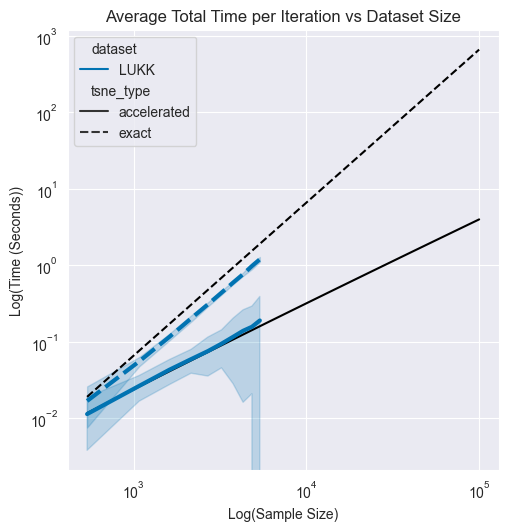

In [6]:
# timings_df.groupby(["dataset", "tsne_type", "sample_size"])["total_time"].std()

plot_times_df = timings_df.copy()
plot_times_df = plot_times_df[(plot_times_df.splitting_strategy == "equal_length")]

_, axs = plt.subplots(figsize=(5, 5), ncols=1)
plt.tight_layout()
# Plot a trendline for the quadratic run times
axs.plot(
    [537, 100000],
    [0.019079, 661.6],
    color=(0, 0, 0, 1.0),
    linestyle="dashed"
)
# Plot a trendline for the lin-log run times
axs.plot(
    list(np.logspace(2.73239376, 5)),
    [0.0000024 * a * np.log2(a) for a in list(np.logspace(2.73239376, 5))],
    color=(0, 0, 0, 1.0)
)

times_lineplot = sns.lineplot(
    data=timings_df,
    x="sample_size",
    y="total_time",
    hue="dataset",
    style="tsne_type",
    errorbar=("sd", 1),
    palette=palette,
    markers=False,
    linewidth=linewidth,
    ax=axs)
times_lineplot.set(xscale='log', yscale='log')

axs.set_title(f"Average Total Time per Iteration vs Dataset Size")
axs.set_xlabel("Log(Sample Size)")
axs.set_ylabel("Log(Time (Seconds))")
plt.show()

# Plot 1b: Plotting the asymptotic coefficients as a box plot

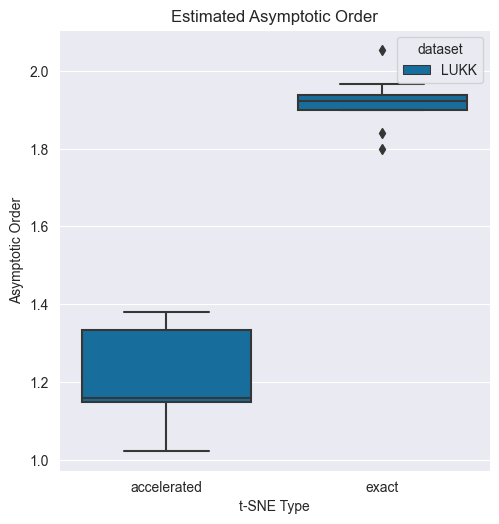

In [7]:
plot_asymptotic_df = get_asymptotic_df(plot_times_df, "tsne_type")

_, axs = plt.subplots(figsize=(5, 5), ncols=1)
plt.tight_layout()
asym_boxplot = sns.boxplot(
    plot_asymptotic_df,
    x="tsne_type",
    y="asymptotic_score",
    hue="dataset", palette=palette)
axs.set_title(f"Estimated Asymptotic Order")
axs.set_xlabel("t-SNE Type")
axs.set_ylabel("Asymptotic Order")
# asym_boxplot.legend().remove()  # _remove_legend()
plt.show()

# Plot 2: Focus on accelerated version. Effect of early_exag and splitting strategy for different sample sizes
facet by stage
line style by splitting strategy
color by dataset

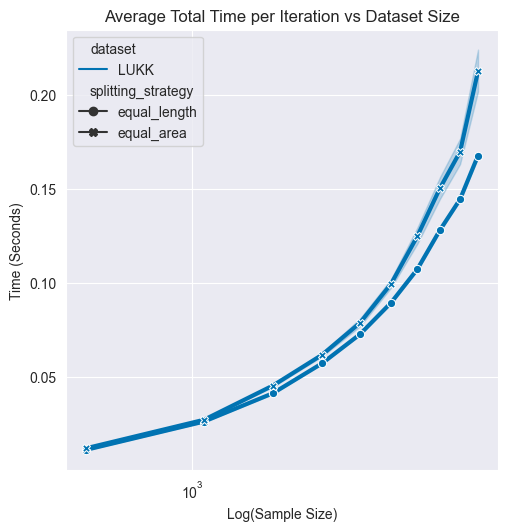

In [8]:
plot_times_df = timings_df.copy()
plot_times_df = plot_times_df[(plot_times_df.tsne_type == "accelerated")]

_, axs = plt.subplots(figsize=(5, 5), ncols=1)
plt.tight_layout()
times_lineplot = sns.lineplot(
    plot_times_df,
    x="sample_size",
    y="total_time",
    hue="dataset",
    style="splitting_strategy",
    # errorbar=("sd", 1),
    palette=palette,
    dashes=False,
    markers=True,
    linewidth=linewidth,
    ax=axs
)
times_lineplot.set(xscale='log')  # , yscale='log')
axs.set_title(f"Average Total Time per Iteration vs Dataset Size")
axs.set_xlabel("Log(Sample Size)")
axs.set_ylabel("Time (Seconds)")
plt.show()

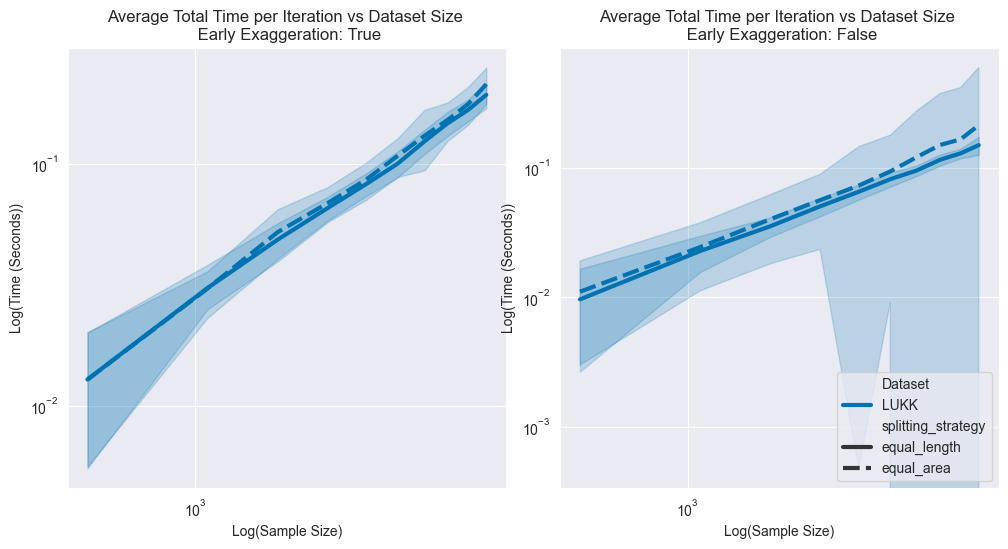

In [9]:
plot_times_df = timings_df.copy()
plot_times_df = plot_times_df.loc[plot_times_df.tsne_type == "accelerated", :]

_, axs = plt.subplots(figsize=(10, 5), ncols=2)
plt.tight_layout()
legends = []

for i, early_exag in enumerate([True, False]):
    filtered_df = plot_times_df.copy()
    filtered_df = filtered_df.loc[filtered_df.early_exag == early_exag, :]
    times_lineplot = sns.lineplot(filtered_df,
                                  x="sample_size",
                                  y="total_time",
                                  hue="dataset",
                                  style="splitting_strategy",
                                  errorbar=("sd", 1), palette=palette, markers=False, linewidth=linewidth, ax=axs[i])
    times_lineplot.set(xscale='log', yscale='log')
    axs[i].set_title(f"Average Total Time per Iteration vs Dataset Size \n Early Exaggeration: {early_exag}")
    axs[i].set_xlabel("Log(Sample Size)")
    axs[i].set_ylabel("Log(Time (Seconds))")
    legends.append(times_lineplot.get_legend())

legends[0].remove()
for line in legends[1].get_lines():
    line.set_linewidth(linewidth)
for t in legends[1].texts:
    if t.get_text() == "dataset":
        t.set_text("Dataset")
    if t.get_text() == "tsne_type":
        t.set_text("Type")

sns.move_legend(axs[1], "lower right")
plt.show()

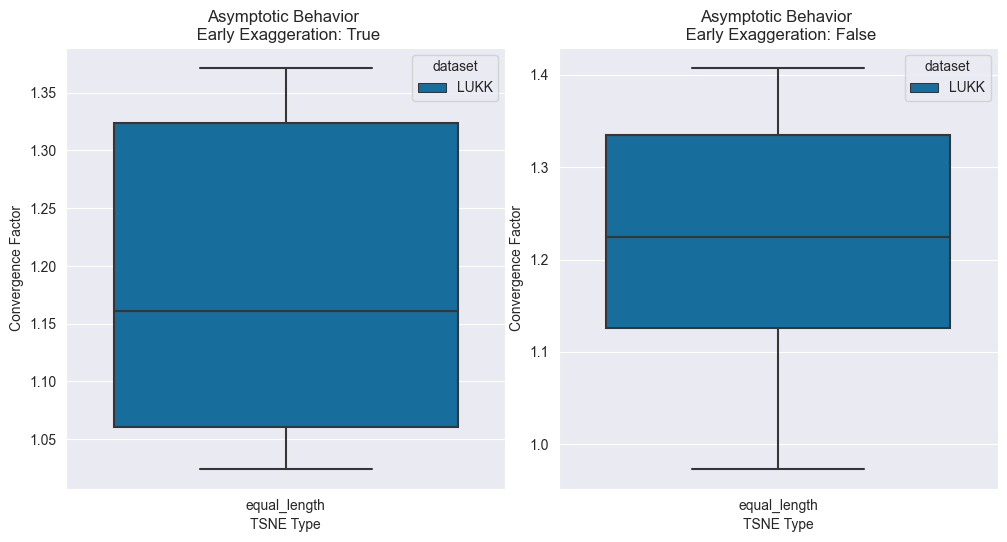

In [10]:
asymptotic_style = ["lineplot", "boxplot"][1]
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
plt.tight_layout()
legends = []

for i, early_exag in enumerate([True, False]):
    filtered_df = plot_times_df.copy()
    filtered_df = filtered_df.loc[filtered_df.early_exag == early_exag, :]
    filtered_asymptotic_df = get_asymptotic_df(filtered_df, "splitting_strategy")
    if asymptotic_style == "lineplot":
        asym_lineplot = sns.lineplot(filtered_asymptotic_df,
                                     x="sample_size",
                                     y="asymptotic_score",
                                     hue="dataset",
                                     style="splitting_strategy", palette=palette, legend=True, markers=False, linewidth=linewidth,
                                     ax=axs[i])
        asym_lineplot.set(xscale='log')
        axs[i].set_title(f"Asymptotic Behavior \n Early Exaggeration: {early_exag}")
        axs[i].set_xlabel("Log(Sample Size)")
        axs[i].set_ylabel("Convergence Factor")
        legends.append(asym_lineplot.get_legend())
    else:
        asym_boxplot = sns.boxplot(filtered_asymptotic_df,
                                   x="splitting_strategy",
                                   y="asymptotic_score",
                                   hue="dataset", palette=palette, ax=axs[i])
        axs[i].set_title(f"Asymptotic Behavior \n Early Exaggeration: {early_exag}")
        axs[i].set_xlabel("TSNE Type")
        axs[i].set_ylabel("Convergence Factor")
        # if i == 0:
        #    asym_boxplot.legend().remove()  # _remove_legend()

if asymptotic_style == "lineplot":
    legends[0].remove()
    for line in legends[1].get_lines():
        line.set_linewidth(linewidth)
    for t in legends[1].texts:
        if t.get_text() == "dataset":
            t.set_text("Dataset")
        if t.get_text() == "tsne_type":
            t.set_text("Type")

# sns.move_legend(axs[1], "upper left")
plt.show()

Average execution time per iteration (seconds) vs sample size
=============================================================
Granularity: one line plot per dataset
Line plot showing how our method scales with increasing sample sizes.
For each combination of (sample_size, HDEO params), we perform T runs.
In each run, we performed I gradient descent iterations.
This means for each (sample_size, HDEO params) combination we have I*T time measurements.
The line plot shows confidence bands for every sample size computed from these measurements.
For the overleaf document we differentiate between:
 - With and without acceleration (black and red dots in Figure 2 in 4.2.1).
 - With acceleration differentiating between with and without early exaggeration iterations (green and blue dots in Figure 2 in 4.2.1).
 - Area equal vs extrinsic half split (Figure 1 in 4.1.1)

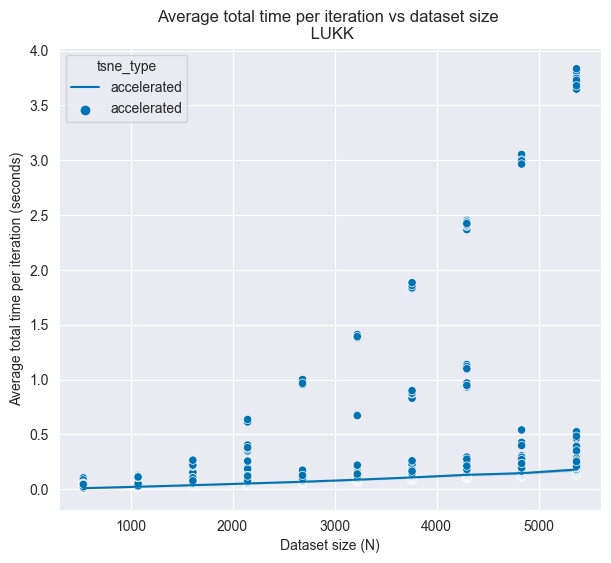

In [11]:
datasets = filtered_df.dataset.unique()
nrows = min(3, len(datasets))
ncols = int(np.ceil(len(datasets) / nrows))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7 * ncols, nrows * 6))
axs = np.array(axs).flatten()
for i, dataset in enumerate(datasets):
    sns.lineplot(data=filtered_df[(filtered_df.dataset == dataset)],
                    x="sample_size", y="total_time", hue="tsne_type", ax=axs[i])
    sns.scatterplot(data=filtered_df[(filtered_df.dataset == dataset)],
                    x="sample_size", y="total_time", hue="tsne_type", ax=axs[i])
    axs[i].set_title(f"Average total time per iteration vs dataset size \n {dataset}")
    axs[i].set_xlabel("Dataset size (N)")
    axs[i].set_ylabel("Average total time per iteration (seconds)")
plt.show()

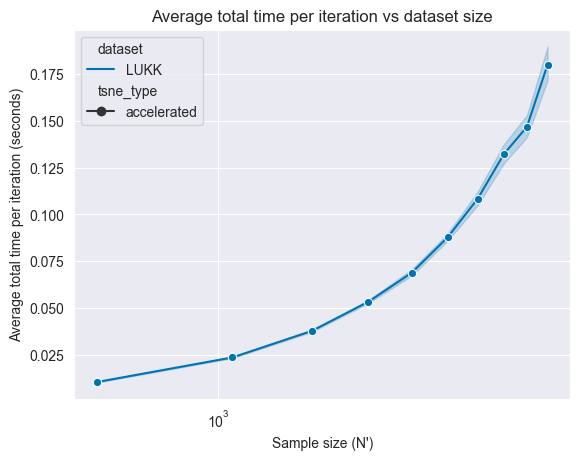

In [12]:
# sns.color_palette("hls", 2)
sns.set_palette("colorblind")
fig, ax = plt.subplots()
times_lineplot = sns.lineplot(filtered_df, x="sample_size", y="total_time", hue="dataset", style="tsne_type", markers=True, ax=ax)
times_lineplot.set(xscale='log')
# sns.scatterplot(filtered_df, x="sample_size", y="total_time", hue="dataset", style="tsne_type")
ax.set_title(f"Average total time per iteration vs dataset size")
ax.set_xlabel("Sample size (N')")
ax.set_ylabel("Average total time per iteration (seconds)")
plt.show()